In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from typing import List, NoReturn, Dict, Union
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, balanced_accuracy_score

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Вспомогательные функции

In [34]:
def build_confusion_matrix(X: pd.DataFrame, y: pd.DataFrame) -> NoReturn:
    '''
        На вход фунция принимает фреймы независимых переменных и зависимых переменных.
        Строится модель случайного леса без настройки параметров, после по тестовым данным
        строится матрица соответсвий                
    '''
    from sklearn.metrics import confusion_matrix, accuracy_score
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=1)

    model = RandomForestClassifier(random_state=150)
    model.fit(X_train, y_train)

    accuracy_test: float = accuracy_score(y_test, model.predict(X_test))
    accuracy_train: float = accuracy_score(y_train, model.predict(X_train))

    conf_mat = confusion_matrix(y_true=y_test, y_pred=model.predict(X_test))
    print('Confusion matrix:\n', conf_mat)

    labels: List[str] = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    return None

In [3]:
def unique_values_count(df: pd.DataFrame
                        ) -> List[Dict[str, Union[str, List[int]]]]:
    '''
        Функциф принимает фрейм данных и возврщает список словарей вида:
            col: названия столбца
            values: количество уникальных значений
    '''
    unique_values: List[Dict[str, Union[str, List[int]]]] = []
    for col in df.columns.tolist():
        dct: Dict[str, Union[str, List[int]]] = {}
        dct['col'] = col
        dct['values'] = df[f'{col}'].unique().tolist()
        unique_values.append(dct)
    return unique_values

In [4]:
def add_work_column(df: pd.DataFrame) -> pd.DataFrame:
    '''
        Функция для добавления дополнительного столбца со значение рабочий или не рабочий двигатель
        Устанавливаем значеия: 1 - рабочее, 0 - не рабочее(последний эпат перед поломкой)
        Возвращает исходный фрейм данных с доп столбцом
    '''
    df['work'] = 1

    # Находим максимальный цикл работы каждого двигателя
    max_period_for_id = df.groupby('id')['cycle'].max().reset_index()

    # Устанавливаем каждому максимальному циклу значение 0
    for ind_i, row_i in df.iterrows():
        for ind_j, row_j in max_period_for_id.iterrows():
            if row_i['id'] == row_j['id'] and row_i['cycle'] == row_j['cycle']:
                df.iloc[ind_i, -1:] = 0

    return df

In [5]:
def identify_single_unique(X: pd.DataFrame) -> List[str]:
    '''
        Функция поиск уникальных значений
        Принимает фрейм независимых переменных, находит все признаки, в которых
        меньше 5 уникальных значений
        Возвращает список признаков
    '''
    unique_counts = X.nunique()
    unique_stats = pd.DataFrame(unique_counts).rename(columns={
        'index': 'features',
        0: 'nunique'
    })
    unique_stats = unique_stats.sort_values(by='nunique', ascending=True)

    record_single_unique = pd.DataFrame(
        unique_counts[unique_counts < 5]).reset_index().rename(columns={
            'index': 'feature',
            0: 'nunique'
        })

    to_drop = list(record_single_unique['feature'])

    record_single_unique = record_single_unique
    return to_drop

In [6]:
def identify_collinear(X: pd.DataFrame,
                       correlation_threshold: float) -> List[str]:
    '''
        Функция поиск корреляции признаков
        На вход принимает фрейм независимых переменных и значение для корреляции
        Возвращает список признаком с высокой корреляцией
    '''
    corr_matrix = X.corr()

    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    to_drop = [
        column for column in upper.columns
        if any(upper[column].abs() > correlation_threshold)
    ]

    record_collinear = pd.DataFrame(
        columns=['drop_feature', 'corr_feature', 'corr_value'])

    for column in to_drop:
        corr_features = list(
            upper.index[upper[column].abs() > correlation_threshold])
        corr_values = list(
            upper[column][upper[column].abs() > correlation_threshold])

        drop_features = [column for _ in range(len(corr_features))]

        temp_df = pd.DataFrame.from_dict({
            'drop_feature': drop_features,
            'corr_feature': corr_features,
            'corr_value': corr_values
        })

        record_collinear = record_collinear.append(temp_df, ignore_index=True)

    record_collinear = record_collinear
    return to_drop

In [7]:
def pltot_normal_dist(X: pd.DataFrame) -> NoReturn:
    X_means = X.mean().reset_index().rename(columns={
        'index': 'indexs',
        0: 'mean'
    })

    plt.figure(figsize=(25, 25))

    for i, column in enumerate(X.columns, 1):
        if len(X_means[X_means.indexs == str(column)]) > 0:
            ax = plt.subplot(5, 4, i)
            ax.title.set_text(
                f'{column} - {X_means[X_means.indexs == str(column)]["mean"].values[0]}'
            )
            sns.distplot(X[column])
    return None

In [8]:
df = pd.read_csv('data.csv')
df = add_work_column(df)
df.drop(['id'], inplace=True, axis=1)

In [9]:
df.head()

,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,...,p14,p15,p16,p17,p18,p19,p20,s1,s2,work
0,1,518.67,1.30,47.47,521.66,2388.02,8138.62,8.42,0.03,392,...,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.00,-0.00,1
1,2,518.67,1.30,47.49,522.28,2388.07,8131.49,8.43,0.03,392,...,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.00,-0.00,1
2,3,518.67,1.30,47.27,522.42,2388.03,8133.23,8.42,0.03,390,...,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.00,0.00,1
3,4,518.67,1.30,47.13,522.86,2388.08,8133.83,8.37,0.03,392,...,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.00,0.00,1
4,5,518.67,1.30,47.28,522.19,2388.04,8133.80,8.43,0.03,393,...,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.00,-0.00,1


# Подготовка данных

## Сбалансируем данные

### Посмотрим на дисбаланс данных

Class 0:  80
Class 1:  16058
Proportion: 200.72 : 1


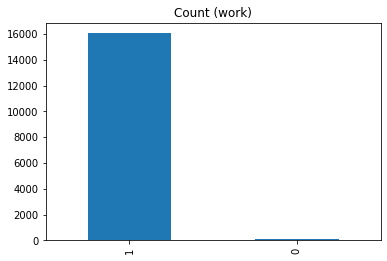

In [10]:
work_count = df.work.value_counts()
print('Class 0: ', work_count[0])
print('Class 1: ', work_count[1])
print('Proportion:', round(work_count[1] / work_count[0], 2), ': 1')
work_count.plot(kind='bar', title='Count (work)')

### матрица соответский

Accuracy train set: 100.0%
Accuracy test: 99.442%
Confusion matrix:
 [[   1   16]
 [   2 3209]]


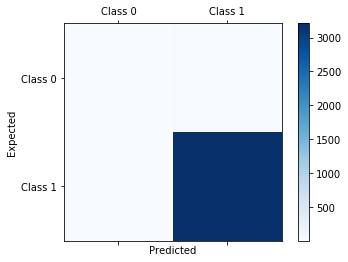

In [11]:
X = df.iloc[:, :-1]
y = df['work']
build_confusion_matrix(X, y)

### Предварительные данные

In [12]:
for i in range(df.cycle.max()):
    if len(df[df.cycle == i]) > 0 and len(df[df.cycle == i]) < 80:
        print(f'Максимальное число циклов без поломок на всех моротрах: {i-1}')
        break

Максимальное число циклов без поломок на всех моротрах: 128


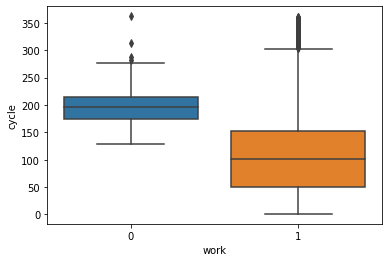

In [13]:
sns.boxplot(y='cycle', x='work', data=df)

из боксплота видно:
- для не работающих двигателей медиана немного смещена;
- усы для класса 0 показывает что поломки начинаются после 128 пероида и только малое количетсво двигателй продолжает работать после 300 периода
- для обоих классов присущи выбросы
- большая часть данных для класса 0 находится между ~(175, 215), для класса 1 между (50. 150)
- у класса 1 большая степень разброса

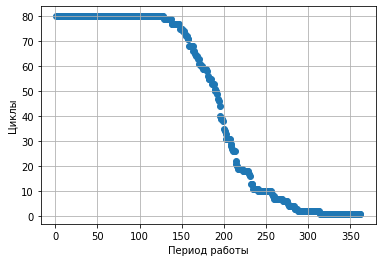

In [14]:
temp = df.groupby(['cycle'])['work'].count().reset_index()
plt.scatter(temp.cycle, temp.work)
plt.ylabel('Циклы')
plt.xlabel('Период работы')
plt.grid()

### Проведем сэмплирование
  - Сначала уберем отдаленные значени из мажоритарного класса (т.к. до 128 периода двигатели работают исправно, половина двигателей прекращает свою работу к 200 циклу(~ 55% периодов)) используя правило сосредоточенного ближайшего соседа 
    
  - Потом добавим искуственные значения для класса 0, методом адаптивной синтетической выборки

In [15]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import CondensedNearestNeighbour

labels = df.columns[:-1]

X = df[labels]
y = df['work']

counter = Counter(y)
print('\t\tUnder-Sampling\n')
print(f'До обработки: {counter}')

cnn = CondensedNearestNeighbour(random_state=42)
X, y = cnn.fit_resample(X, y)

counter = Counter(y)
print(f'После обработки: {counter}')

counter = Counter(y)

print('\n\n\t\tOver-Sampling\n')
print(f'До обработки: {counter}')

adasyn = ADASYN(random_state=42, n_jobs=-1)

X, y = adasyn.fit_resample(X, y)
counter = Counter(y)
print(f'После обработки: {counter}')

		Under-Sampling

До обработки: Counter({1: 16058, 0: 80})
После обработки: Counter({1: 292, 0: 80})


		Over-Sampling

До обработки: Counter({1: 292, 0: 80})
После обработки: Counter({0: 295, 1: 292})


Accuracy train set: 100.0%
Accuracy test: 93.22%
Confusion matrix:
 [[63  4]
 [ 4 47]]


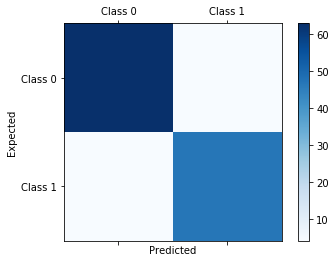

In [16]:
build_confusion_matrix(X, y)

## Отбор признаков

### Отберем признаки с единственными значениями

In [17]:
drop_col = identify_single_unique(X)
print(f'Признаки которые были удалены\n{drop_col}')
X.drop(drop_col, axis=1, inplace=True)

Признаки которые были удалены
['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17']


### Посмотрим на распределение данных

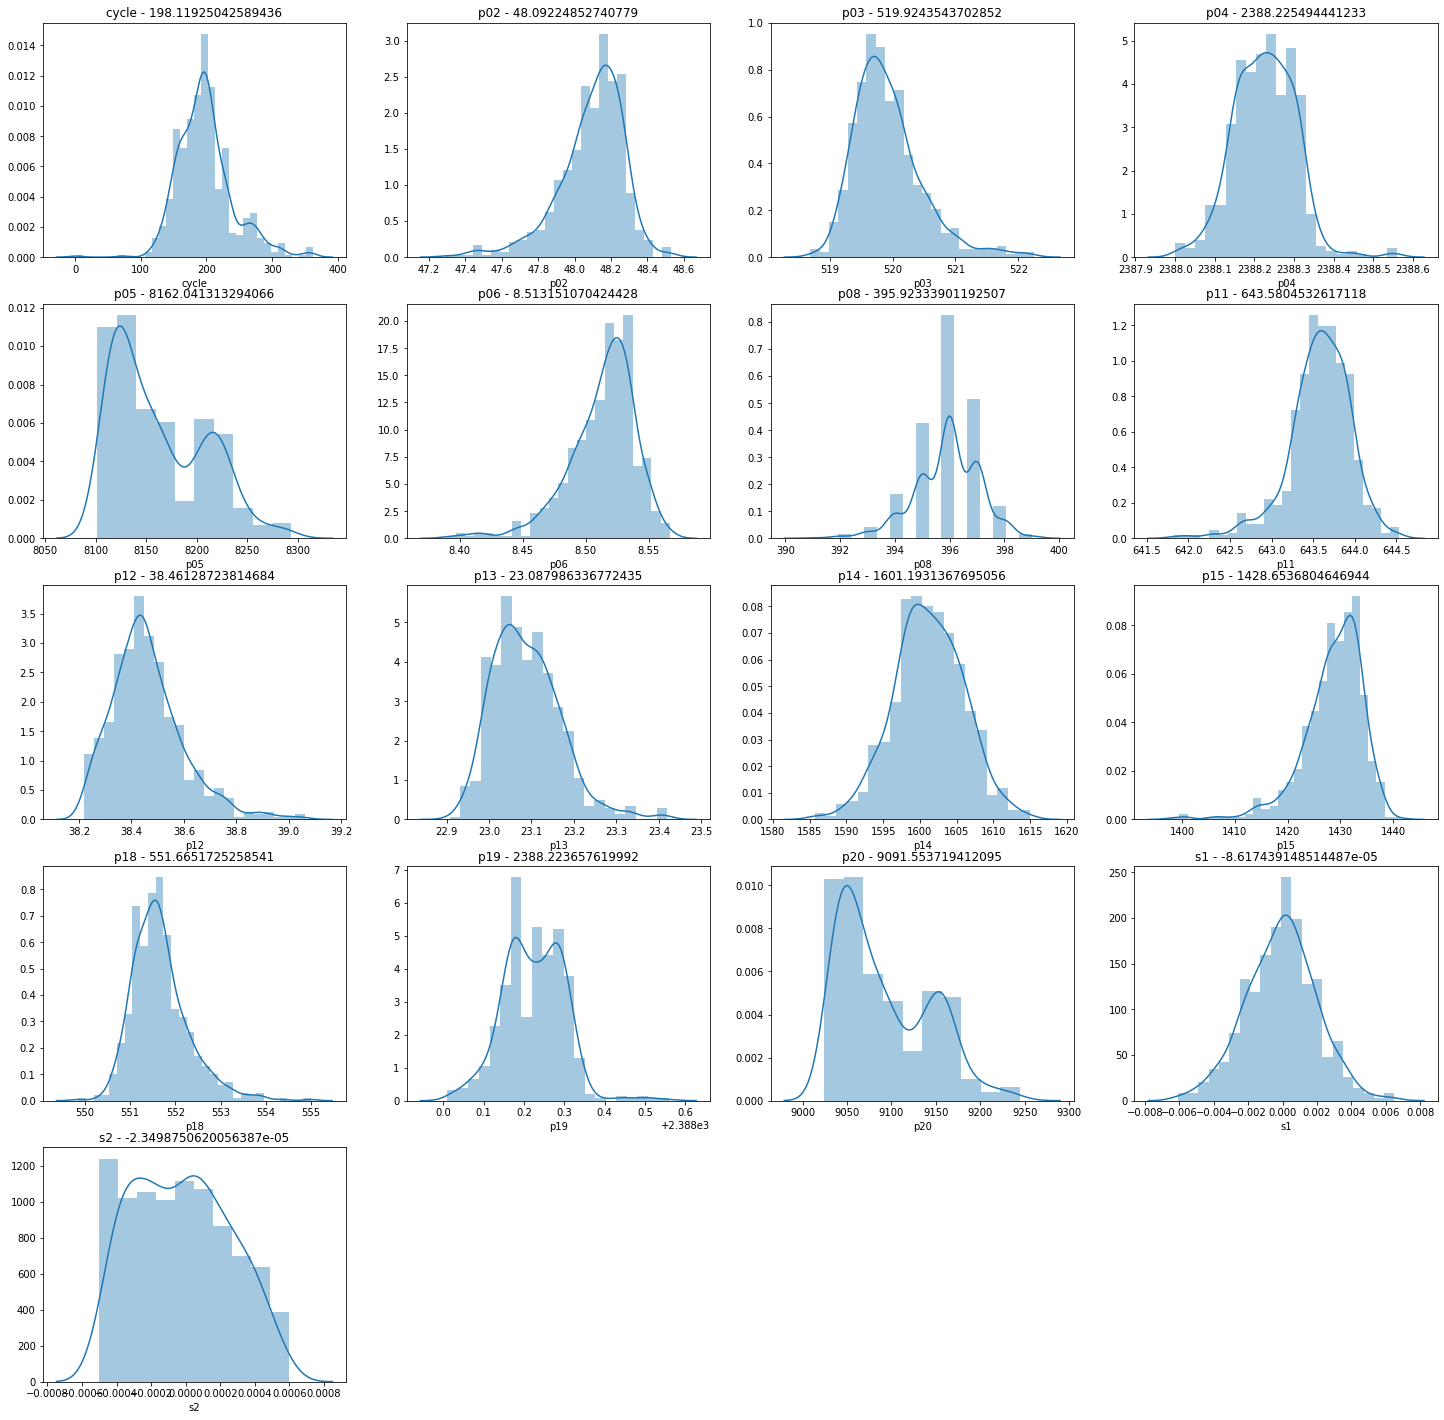

In [18]:
pltot_normal_dist(X)

### Посмотрим корреляцию

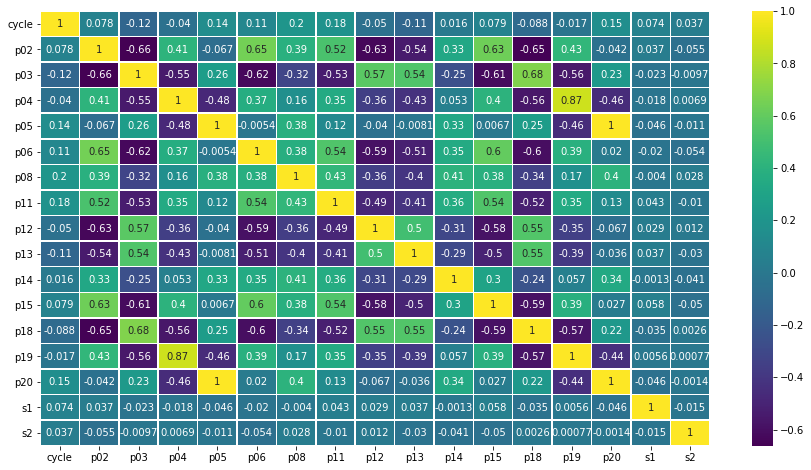

In [19]:
plt.figure(figsize=(15, 8))
ax = sns.heatmap(X.corr(), cmap='viridis', annot=True, linewidths=.5)

In [20]:
# Удалим все признаки с корреляцией больеш 0.7 по модулю
del_col = identify_collinear(X, 0.7)
X.drop(del_col, axis=1, inplace=True)

# Выбор модели

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Построение модели
- построим случайный лес деревьев и настроим параметры
- К достоинствам использования случайного леса для прогнозирования в какой период откажет двигатель относится:
    
    - выявление латентных свсязей у нескольких признаков, коггда на значение одного признака оказывается воздействие другой или другие признаки
    - в процессе обучения алгоритм может выявлять значимые параметры, которую в первую очередь влияют на прогноз, и откидывать менее значимые параметры
- Метрику оценки выберем как сбалансированная точность

### Проведем настройку гиперпараметров по сетке

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': list(range(10, 101, 10)),
    'max_depth': list(range(10, 15)),
    'max_features': list(range(1, 8)),
    'min_samples_leaf': list(range(1, 10)),
}

rf = RandomForestClassifier(random_state=0, oob_score=True)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='recall',
                           verbose=2)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

grid_search.best_estimator_

Fitting 5 folds for each of 3150 candidates, totalling 15750 fits


RandomForestClassifier(max_depth=11, max_features=1, min_samples_leaf=2,
                       n_estimators=30, oob_score=True, random_state=0)

## Посмотрим оценку модели

### Balanced Accuracy
- В нашем случае у нас есть дисбаланс классов, используем сбалансированную точность - это среднее полноты всех классов

In [28]:
balanced_accuracy_score(y_test, y_pred)

0.9013377926421404

### Recall
- какой процент работающих двигателей модель предсказала как "работающие"

In [29]:
recall_score(y_test, y_pred)

0.8461538461538461

### Precision
- Какой процент работающих двигателей правильно классифирован

In [30]:
precision_score(y_test, y_pred)

0.9565217391304348

### Specificity
- Процент правильно классифицированныхне работающих двигателей

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn / (tn + fp)

0.9565217391304348

### Матрица соответсвий

Accuracy train set: 100.0%
Accuracy test: 86.667%
Confusion matrix:
 [[14  2]
 [ 2 12]]


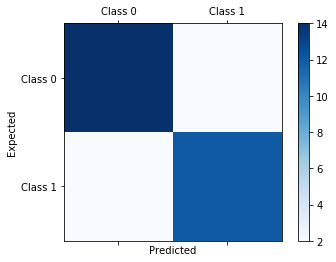

In [33]:
build_confusion_matrix(X_test, y_pred)